In [1]:

import os, sys

import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np
from numba import guvectorize

from utils.dask import load_chunk, mmap_dask_array

In [2]:
repeat_counts = []
for i in range(10):
    repeat_counts.append(np.load(f"../results/repeat_count/repeat_count_{i}-01.npy"))
counts = np.stack(repeat_counts, axis=1)

In [3]:
nonrepeats = np.sum(counts, axis=1)[:, 8] < 5

In [4]:
df = pd.read_parquet('../results/analysis.parquet.gzip')  

In [5]:
["index"] + [f"match{2**i}" for i in range(0, 9)]
all_dfs = []
for i in range(10000, 20001, 1000):
    df = pl.scan_csv(f"../results/memorization-dyn-count/evals-running/memorization_1b-v0_{i}_10240000_lev/*.csv", has_header=False, 
            new_columns = ["index", "longest_match", "overlap", "lev"])
    # df["index"] = df["index"].cast(pl.Int64)
    df = df.with_columns(checkpoint = pl.lit(i))
    all_dfs.append(df)
all_dfs = pl.concat(all_dfs)

In [6]:
all = all_dfs.collect().to_pandas()
indices_0_1 = (all["lev"] > 60) & (all["checkpoint"] == 10000)
indices_mem = all.groupby("index").min()["lev"] < 10
indices_0_1 =  np.array(
    list(set(indices_mem[indices_mem].index.tolist()).intersection(
        set(all[(all["lev"] > 50) & (all["checkpoint"] == 10000)]["index"].tolist()))))

In [7]:
indices_neg = all.groupby("index").min()["lev"] > 50
indices_0_0 =  np.array(
    list(set(indices_mem[indices_neg].index.tolist()).intersection(
        set(all[(all["lev"] > 50) & (all["checkpoint"] == 10000)]["index"].tolist()))))

In [8]:
indices_0_0.shape

(841699,)

In [9]:
np.save('0_0', indices_0_0[:1000])
np.save('0_1', indices_0_1)

In [10]:
# perturbs = []
# indices = []
# gt = []
# orig = []
# for i in range(3, 17):
#     data = np.load(f'perturbation-19000-{i}.npz')
#     perturbs.append(data["results"])
#     indices.append(data["indices"])
#     orig.append(data["gen_orig"])
#     gt.append(data["data"])
# perturb0 = np.concatenate(perturbs, axis=1)
# indices0 = np.concatenate(indices)
# gt0 = np.concatenate(gt)
# ori0 = np.concatenate(orig)

In [11]:
perturbs = []
indices = []
gt = []
orig = []
for i in range(0, 17):
    data = np.load(f'../results/perturbation/perturbation-10000-{i}-01.npz')
    perturbs.append(data["results"])
    indices.append(data["indices"])
    orig.append(data["gen_orig"])
    gt.append(data["data"])
perturb00 = np.concatenate(perturbs, axis=1)
indices00 = np.concatenate(indices)
gt00 = np.concatenate(gt)
ori00 = np.concatenate(orig)

In [12]:
perturbs = []
indices = []
gt = []
orig = []
for i in range(0, 17):
    data = np.load(f'../results/perturbation/perturbation-10000-{i}-00.npz')
    perturbs.append(data["results"])
    indices.append(data["indices"])
    orig.append(data["gen_orig"])
    gt.append(data["data"])
perturb00_neg = np.concatenate(perturbs, axis=1)
indices00_neg = np.concatenate(indices)
gt00_neg = np.concatenate(gt)
ori00_neg = np.concatenate(orig)

In [13]:
perturbs = []
indices = []
gt = []
orig = []
for i in range(0, 15):
    data = np.load(f'../results/perturbation/perturbation-10000-{i}_control.npz')
    perturbs.append(data["results"])
    indices.append(data["indices"])
    orig.append(data["gen_orig"])
    gt.append(data["data"])
perturb_control = np.concatenate(perturbs, axis=1)
indices_control = np.concatenate(indices)
gt_control = np.concatenate(gt)
orig_control = np.concatenate(orig)

In [14]:
perturbs = []
indices = []
gt = []
orig = []
for i in range(0, 17):
    data = np.load(f'../results/perturbation/perturbation-19000-{i}-01.npz')
    perturbs.append(data["results"])
    indices.append(data["indices"])
    orig.append(data["gen_orig"])
    gt.append(data["data"])
perturb = np.concatenate(perturbs, axis=1)
indices = np.concatenate(indices)
gt = np.concatenate(gt)
orig = np.concatenate(orig)

In [15]:

dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
MODEL='1b-v0'
CHECKPOINT=10000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).half().eval().cuda()

data = np.array([dataset[idx.astype(np.int32).item()] for idx in indices])
context_tokens = torch.tensor(data[:, :32].astype(np.int32)).to('cuda')
with torch.no_grad():
    gen = model.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 96, min_length = 96)


    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and 

In [16]:

dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
MODEL='1b-v0'
CHECKPOINT=10000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).half().eval().cuda()

data = np.array([dataset[idx.astype(np.int32).item()] for idx in indices00_neg])
context_tokens = torch.tensor(data[:, :32].astype(np.int32)).to('cuda')
with torch.no_grad():
    gen_neg = model.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 96, min_length = 96)


    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and 

In [17]:
@guvectorize(["void(int64[:,:], int64[:,:], int64[:])"],
             "(n,i),(n,j)->(n)")
def levenshtein_distance(a, b, result):
    d = np.zeros((a.shape[0], a.shape[1]+1, 2))
    for i in range(0, a.shape[1]+1):
        d[:, i, 0] = i
    for j in range(1, b.shape[1]+1):
        d[:, 0, j % 2] = j
        for i in range(1, a.shape[1]+1):
            substitution_cost = (a[:, i-1] != b[:, j-1])
            for k in range(a.shape[0]):
                d[k, i, j % 2] = min(
                        (d[k, i-1, j % 2] + 1,
                         d[k, i, (j-1) % 2] + 1,
                         d[k, i-1, (j-1) % 2] + substitution_cost[k]
                        )
                )
    result[:] = d[:, -1, (b.shape[-1]) % 2]


In [18]:
dists = []
for i in tqdm(range(200)):
    dists.append(levenshtein_distance(perturb[i, :, 32:96], gt[:, 32:96]))
dists = np.stack(dists)

100%|██████████| 200/200 [00:02<00:00, 78.23it/s]


In [19]:
dists0 = []
for i in tqdm(range(200)):
    dists0.append(levenshtein_distance(perturb00[i, :, 32:96], gt[:, 32:96]))
dists0 = np.stack(dists0)

100%|██████████| 200/200 [00:02<00:00, 79.15it/s]


In [20]:
# maxvals = df.groupby(df.index.get_level_values(0)).transform('max') 
# minvals = df.groupby(df.index.get_level_values(0)).transform('min') 
# indices_0_1 = np.array(list(set(df[(df["lev"] > 50 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
#     set(df[(minvals["lev"] < 20) & (maxvals["cumsum30"] < 15)].index.get_level_values(0).to_numpy()))))
# indices_0_0 = np.array(list(set(df[(df["lev"] > 60 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
#     set(df[minvals["lev"] >= 10].index.get_level_values(0).to_numpy()))))

In [21]:
dists_control = []
for i in tqdm(range(200)):
    dists_control.append(levenshtein_distance(perturb_control[i, :, 32:96], gt_control[:, 32:96]))
dists_control = np.stack(dists_control)

100%|██████████| 200/200 [00:54<00:00,  3.65it/s]


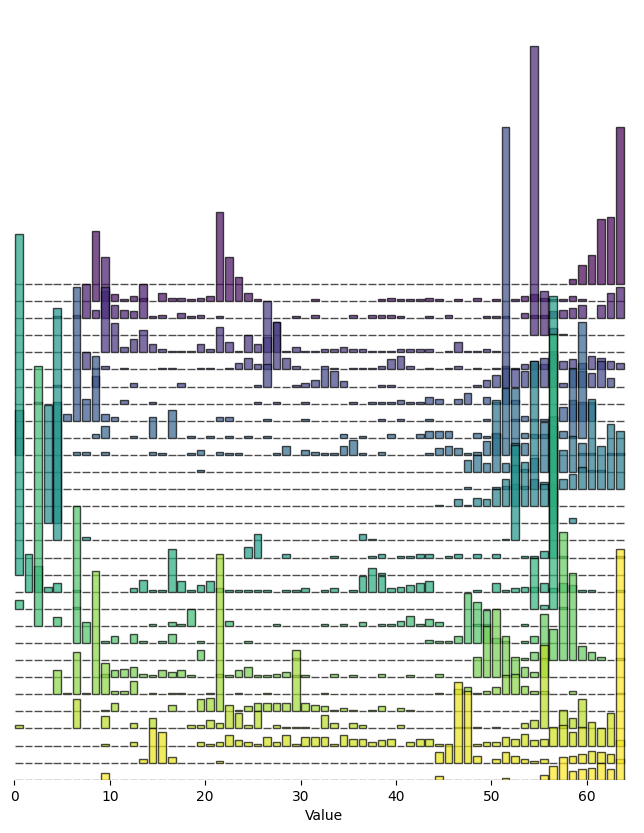

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: 5 different distributions
np.random.seed(0)
data = dists.T[:30, :]

# Create the ridge plot
fig, ax = plt.subplots(figsize=(8, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

# Parameters for controlling the overlap
overlap = 0.7

for i, (color, dist) in enumerate(zip(colors, data)):
    counts, bins = np.histogram(dist, bins=np.arange(0, 65))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, counts/10, alpha=0.7, color=color, edgecolor='k',
           bottom=-i * 1.0+50)

ax.set_yticks([])
ax.set_xlabel('Value')
ax.set_xlim(0, 65)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(False)
fig.savefig("../figures/perturbation_dist.pdf")


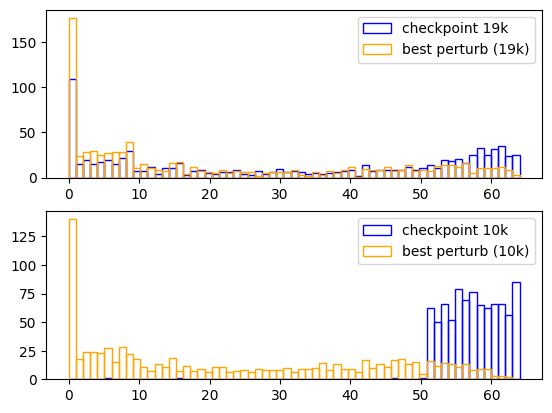

In [23]:
base_dists = levenshtein_distance(orig[:, 32:96], gt[:, 32:96])
orig_dists = levenshtein_distance(gen.detach().cpu().numpy()[:, 32:96], gt[:, 32:96])
f, ax = plt.subplots(2, 1)

ax[0].hist(base_dists, bins=np.linspace(0, 64, 64), alpha=1.0, label='checkpoint 19k', edgecolor='blue', fill=False)
vals = np.min(dists, axis=0)
ax[0].hist(vals, bins=np.linspace(0, 64, 64), alpha=1.0, label='best perturb (19k)', edgecolor='orange', fill=False)
ax[1].hist(orig_dists, bins=np.linspace(0, 64, 64), alpha=1.0, label='checkpoint 10k', edgecolor='blue', fill=False)
vals0 = np.min(dists0, axis=0)
ax[1].hist(vals0, bins=np.linspace(0, 64, 64), alpha=1.0, label='best perturb (10k)', edgecolor='orange', fill=False)

ax[0].legend()
ax[1].legend()
f.savefig("../figures/perturb_10k_19k.pdf")

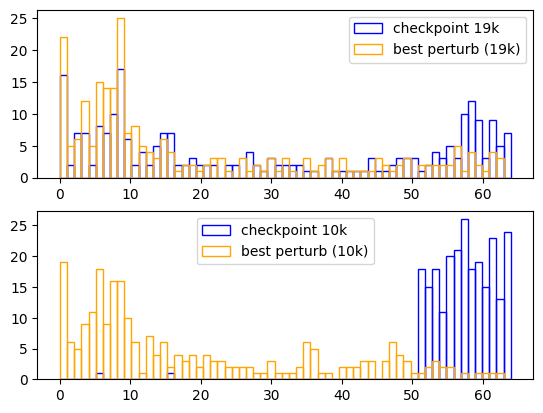

In [24]:
f, ax = plt.subplots(2, 1)
base_dists = levenshtein_distance(orig[:, 32:96], gt[:, 32:96])
orig_dists = levenshtein_distance(gen.detach().cpu().numpy()[:, 32:96], gt[:, 32:96])
ax[0].hist(base_dists[nonrepeats], bins=np.linspace(0, 64, 64), alpha=1, label='checkpoint 19k', edgecolor='blue', fill=False)
vals = np.min(dists, axis=0)
ax[0].hist(vals[nonrepeats], bins=np.linspace(0, 64, 64), alpha=1, label='best perturb (19k)', edgecolor='orange', fill=False)
ax[1].hist(orig_dists[nonrepeats], bins=np.linspace(0, 64, 64), alpha=1, label='checkpoint 10k', edgecolor='blue', fill=False)
vals0 = np.min(dists0, axis=0)
ax[1].hist(vals0[nonrepeats], bins=np.linspace(0, 64, 64), alpha=1, label='best perturb (10k)', edgecolor='orange', fill=False)
ax[1].legend()
ax[0].legend()
f.savefig("../figures/norepeat_10k_19k.pdf")

Text(0.5, 1.0, 'Difference between 19k and perturbations')

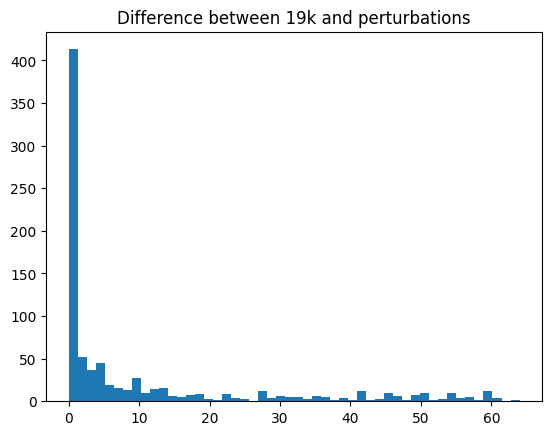

In [25]:
# plt.hist(orig_dists - np.min(dists, axis=0))
diff = (base_dists - np.min(dists, axis=0))
plt.hist(diff, bins=50)
plt.title('Difference between 19k and perturbations')

In [26]:
dists00 = []
for i in tqdm(range(200)):
    dists00.append(levenshtein_distance(perturb00_neg[i, :, 32:96], gt00_neg[:, 32:96]))
dists00 = np.stack(dists00)

100%|██████████| 200/200 [00:02<00:00, 69.65it/s]


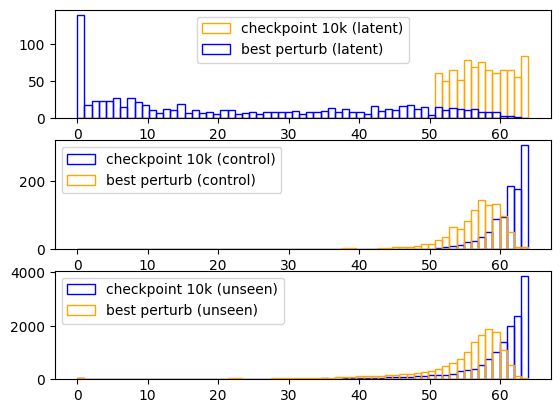

In [27]:
# gen_neg - gt
# perturb00_neg = np.concatenate(perturbs, axis=1)
# indices00_neg = np.concatenate(indices)
# gt00_neg = np.concatenate(gt)
# ori00_neg = np.concatenate(orig)
f, ax = plt.subplots(3, 1)
vals = np.min(dists00, axis=0)
orig_dists00 = levenshtein_distance(gen_neg.detach().cpu().numpy()[:, 32:96], gt00_neg[:, 32:96])
ax[1].hist(orig_dists00, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False, label='checkpoint 10k (control)')
ax[1].hist(vals, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False,  label='best perturb (control)')
ax[0].hist(orig_dists, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False, label='checkpoint 10k (latent)')
ax[0].hist(vals0, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False, label='best perturb (latent)')

dist_orig_control = levenshtein_distance(orig_control[:, 32:96], gt_control[:, 32:96])
vals_control = np.min(dists_control, axis=0)

ax[2].hist(dist_orig_control, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False,  label='checkpoint 10k (unseen)')
ax[2].hist(vals_control, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False, label='best perturb (unseen)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
f.savefig("../figures/10k_control.pdf")

## Old

In [124]:
initial_dists = levenshtein_distance(perturb["gen_orig"], data[:, :288])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Text(0.5, 0, 'minimum levenshtein distance')

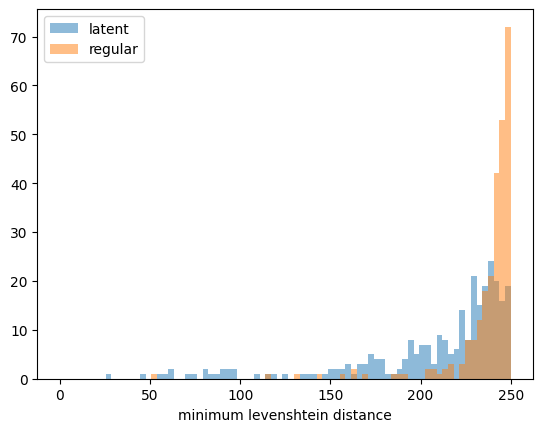

In [29]:
vals = initial_dists
plt.hist(vals[:302], bins=np.linspace(0, 250, 80), alpha=0.5, label='latent')
plt.hist(vals[302:], bins=np.linspace(0, 250, 80), alpha=0.5, label='regular')
plt.legend()
plt.xlabel('minimum levenshtein distance')

Text(0.5, 0, 'minimum levenshtein distance delta')

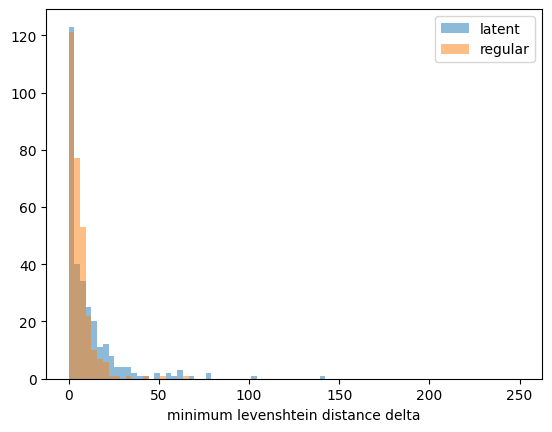

In [33]:
vals = initial_dists - np.min(dists, axis=0)
plt.hist(vals[:302], bins=np.linspace(0, 250, 80), alpha=0.5, label='latent')
plt.hist(vals[302:], bins=np.linspace(0, 250, 80), alpha=0.5, label='regular')
plt.legend()
plt.xlabel('minimum levenshtein distance delta')

In [84]:
perturb["gen_orig"][5]

array([  253,  4156, 48324,  2900,  2529,   407,   253,  1386,  3284,
        1764,  1968,    92, 14456,  3837,    52,    94,   187,    61,
        2009,    92,    72,    94,   426,   428,    71,     9,    83,
          10,  7064,    63,    19,  2766,  1124,    92,    18,  1217,
          71,     9,    83,  3117,  5267,    63,    19,    12,    83,
          63,    19,    69,    61,  4153,    63,    19, 11227,   835,
         370,    71,     9,    83,  1009,   310,   253, 48324, 16841,
        1159,    15,   380,  7982,   370,    72,     5,   310,  1677,
         407,   253, 48324, 16841,  1159,   370,    51,     9,    83,
        1009,   285,   253,  7982,   370,    72,     5,   310,  1677,
         407,   253, 48324, 16841,  1159,   370,    51,     9,    83,
        4010,    51,     9,    83,    13,    17,  3822,   380,  7982,
         370,    72,     5,   310,   247,  2900,   273,   253, 21003,
          14,  9684,  4714,  7424,  1764,  1968,    92, 48987,    14,
        9684,  4714,

In [81]:
np.argwhere(dists[:, 5] == 0)

array([[ 43],
       [193]])

In [87]:
res1 = np.max(np.sum(perturb["results"] == perturb["gen_orig"], -1), 0)[:302]
res0 = np.max(np.sum(perturb["results"] == perturb["gen_orig"], -1), 0)[302:]

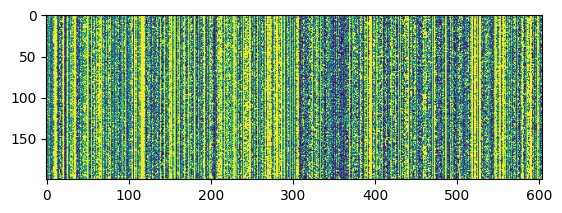

In [28]:
plt.imshow(np.sum(perturb["results"] == perturb["gen_orig"], -1))

In [91]:
res1
res0

array([288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 133, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 28

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   5.10204082,  10.20408163,  15.30612245,
         20.40816327,  25.51020408,  30.6122449 ,  35.71428571,
         40.81632653,  45.91836735,  51.02040816,  56.12244898,
         61.2244898 ,  66.32653061,  71.42857143,  76.53061224,
         81.63265306,  86.73469388,  91.83673469,  96.93877551,
        102.04081633, 107.14285714, 112.24489796, 117.34693878,
        122.44897959, 127.55102041, 132.65306122, 137.75510204,
        142.85714286, 147.95918367, 153.06122449, 158.16326531,
        163.26530612, 168.36734694, 173.46938776, 178.57142857,
        183.67346939, 188.7755102 , 193.87755102, 198.97959184,
        204.08163265, 209.18367347, 214.28571429, 219.3877551 ,
        224.48979592, 229.59183673, 234.69387755, 239.79591837,
        24

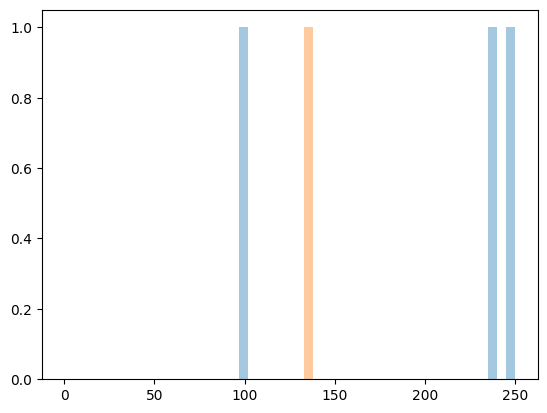

In [88]:
plt.hist(res1, bins=np.linspace(0, 250, 50), alpha=0.4)
plt.hist(res0, bins=np.linspace(0, 250, 50), alpha=0.4)
